In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import json
import numpy as np
import geopandas as gpd
import tqdm.auto as tqdm
import pandas as pd
from permacache import stable_hash
import matplotlib.pyplot as plt
import collections
from urbanstats.geometry.shapefiles.shapefiles_list import shapefiles
from urbanstats.geometry.relationship import full_relationships
from urbanstats.special_cases.country import subnational_regions
from urbanstats.data.circle import overlapping_circles_fast
from urbanstats.website_data.table import (
    shapefile_without_ordinals,
    compute_statistics_for_shapefile,
)
from urbanstats.ordinals.compress_counts import (
    uncompress_counts_sequence,
    compress_counts_sequence,
)
from urbanstats.statistics.output_statistics_metadata import internal_statistic_names
from urbanstats.universe.universe_list import all_universes, default_universes
from urbanstats.geometry.relationship import ordering_idx as type_ordering_idx

/home/kavi/anaconda3/envs/urbanstats-310/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# ! pip install torch --index-url https://download.pytorch.org/whl/cpu

In [49]:
from urbanstats.games.quiz_region_types import QUIZ_REGION_TYPES_ALL
from urbanstats.games.quiz import (
    min_pop,
    min_pop_international,
    minimum_population,
    filter_for_pop,
    stats_to_types,
    difficulty_multiplier,
    get_statistic_categories,
    finish_quiz,
)
from urbanstats.games.quiz_question_distribution import *
from urbanstats.games.quiz_columns import *
from urbanstats.games.quiz_data import *
from urbanstats.games.quiz_regions import *
from urbanstats.games.quiz_question_metadata import *

In [4]:
from collections import Counter

cat_sizes = Counter(get_statistic_categories().values())

In [5]:
# size_each = {k : available_questions[k][0].shape[0] for k in available_questions}

In [6]:
t = shapefile_without_ordinals().copy()
t["local_region_mask"] = t.universes.apply(lambda x: "Canada" in x or "USA" in x)
filtered_for_pop = t[
    t.best_population_estimate
    > t.local_region_mask.apply(lambda x: min_pop if x else min_pop_international)
]

computing statistics:   0%|          | 0/40 [00:00<?, ?it/s]

In [7]:
from urbanstats.statistics.statistics_tree import statistics_tree

In [8]:
# universes, a = pull(filtered_for_pop, region_map["city"])

In [9]:
geographies_by_type = {
    k: r.load_quiz_table(filtered_for_pop) for k, r in region_map.items()
}
# qqp = QuizQuestionPossibilities.compute_quiz_question_possibilities(geographies_by_type)
prob_res = produce_quiz_question_weights(geographies_by_type)

  0%|          | 0/9 [00:00<?, ?it/s]

/home/kavi/census-centroid-blocks/population_density/urbanstats/games/quiz_question_distribution.py:53: RuntimeWarning: divide by zero encountered in divide
  np.abs(vals_a - vals_b) / np.minimum(np.abs(vals_a), np.abs(vals_b)) * 100
/home/kavi/census-centroid-blocks/population_density/urbanstats/games/quiz_question_distribution.py:53: RuntimeWarning: invalid value encountered in divide
  np.abs(vals_a - vals_b) / np.minimum(np.abs(vals_a), np.abs(vals_b)) * 100
/home/kavi/census-centroid-blocks/population_density/urbanstats/games/quiz_question_distribution.py:56: RuntimeWarning: divide by zero encountered in divide
  adj_pct_diff = raw_pct_diff / compute_difficulty_multipliers(qt)
/home/kavi/census-centroid-blocks/population_density/urbanstats/games/quiz_question_distribution.py:56: RuntimeWarning: invalid value encountered in divide
  adj_pct_diff = raw_pct_diff / compute_difficulty_multipliers(qt)


0 6.4831318855285645
10 0.693443775177002
20 0.4668898582458496
30 0.38667920231819153
40 0.3571377992630005
50 0.33495205640792847
60 0.327789843082428
70 0.32226526737213135
80 0.31811970472335815
90 0.3175170421600342


In [10]:
prob_res["qqp"].questions_by_number

[ValidQuizQuestions(geography_index_a=array([1162, 1162, 2164, ...,  617,  143,  143]), geography_index_b=array([ 852, 1373, 1373, ..., 1110, 1657,  224]), stat_indices=array([135, 135, 135, ...,  92,  91,  91])),
 ValidQuizQuestions(geography_index_a=array([1162, 1162,  852, ..., 1579, 1579, 2195]), geography_index_b=array([2164,  419, 1373, ...,  438, 2294,  362]), stat_indices=array([135, 135, 135, ...,  91,  91,  25])),
 ValidQuizQuestions(geography_index_a=array([2164,  419, 1373, ...,   62, 1143, 2145]), geography_index_b=array([ 852,  852, 1867, ...,  239, 1754,  239]), stat_indices=array([135, 135, 135, ...,  28,  28,  28])),
 ValidQuizQuestions(geography_index_a=array([1697, 1697, 1691, ..., 1143,  949,  119]), geography_index_b=array([1867, 1873, 1867, ..., 2145, 1754,  239]), stat_indices=array([135, 135, 135, ...,  28,  28,  28])),
 ValidQuizQuestions(geography_index_a=array([2164, 1373, 1373, ...,  119,  119, 1754]), geography_index_b=array([ 419, 1697, 1691, ..., 1754, 21

In [11]:
qqp = prob_res["qqp"]
ps = prob_res["ps"]
for pi in ps:
    pi /= pi.sum()

In [12]:
bar = 1e-7
ps[0][(ps[0] < bar)].sum(), ((ps[0] < bar)).mean()

(0.010600127, 0.3626051298312878)

In [13]:
vqq = qqp.questions_by_number[0][(ps[0] < bar)]

In [14]:
prob = vqq[0]

In [15]:
qqp.all_geographies[prob.geography_index_a], qqp.all_geographies[
    prob.geography_index_b
], qqp.all_stats[prob.stat_indices]

('Los Angeles city, California, USA', 'Houston city, Texas, USA', 'population')

In [16]:
[len(q) / 1e6 for q in qqp.questions_by_number]

[1.38757, 1.434182, 2.121253, 3.371726, 13.569548]

In [17]:
# ps[2].sum()

In [106]:
seed = 6
rng = np.random.RandomState(seed)
quiz = []
for pi, qs in zip(ps, qqp.questions_by_number):
    idx = rng.choice(pi.shape[0], p=pi)
    q = qs[idx]
    a, b = (
        qqp.all_geographies[q.geography_index_a],
        qqp.all_geographies[q.geography_index_b],
    )
    s = qqp.all_stats[q.stat_indices]
    print(a, b, s)
    stat_a, stat_b = filtered_for_pop.set_index("longname").loc[[a, b], s]
    quiz.append(
        dict(
            stat_column_original=s,
            longname_a=a,
            longname_b=b,
            stat_a=stat_a,
            stat_b=stat_b,
        )
    )

Wichita-Hutchinson KS Media Market, USA Colorado Springs-Pueblo CO Media Market, USA ad_1_change_2010
Urban Honolulu MSA, HI, USA Springfield MSA, MA, USA rent_2br_under_750
TX-09, USA WI-07, USA lapop1share_usda_fra_1
Philadelphia city, Pennsylvania, USA San Francisco city, California, USA OBESITY_cdc_2
Washoe County, Nevada, USA Cumberland County, North Carolina, USA generation_genalpha


In [107]:
url = "http://teroknor:8000"

In [108]:
fq = [{**q, "kind": "juxtastat"} for q in finish_quiz(quiz)]

In [112]:
import gzip, base64, urllib

compressed = gzip.compress(
    json.dumps(dict(name=f"Preview #{seed}", questions=fq)).encode("utf-8"),
    mtime=0,
)
custom = base64.b64encode(compressed).decode("utf-8")

print(url + "/quiz.html#mode=custom&quizContent=" + urllib.parse.quote_plus(custom))

http://teroknor:8000/quiz.html#mode=custom&quizContent=H4sIAAAAAAAC%2F41VDW%2FbNhD9K1dvRRPADqhvadgwpO7aBEsao3aQDcMgnKWzxUUmPZJKGhT97z3aThDHcRDAgCnx3de7d6dvPYUL6v0CvZGhG0m38FPa60Pv%2F46sk1pZvvrnW886dGWl226hVtgr%2BEDKSncHB%2Ba34HpxCMMG1ZzgIBSBGIQiFIfezcpuia7xVliXQVmtcKWHPY7j7xs5b8jAW5CqMoSW%2BABLvexa9JDBLTHAUQ31k9gzoxfgPYLT4GO%2FmVxcnE1ORzB6wVpaqPRi2fl307vNWao5uIYeQLfSNZyFfzWXN6TAYC07CzNtgLBqYEnGagUbjKE5xwJUtX%2Fkww0ZnN87NWS71tkjmDQcnH8IU3KOa15wuZ0h0LOt6K5BxxH0siXAynXYtndAXzmmJFXRkWew1Wrue1ii5%2FBKVo10ODjpHB%2BUT%2B3PMZxTLRHO0VyT68Pl%2BHjLcOoNh7rVXJuG8dJwvnYw6mjaahhePG%2B96qwPORBHIoiSNA2KJI3jJBFxGtwDvGu%2BT8I0CkSe5nGapnEoEr6%2Flqr2gf%2Frvjr04N73PuwoLXz%2FBb6QcvAr%2FJwlAt7uqMrwbRlOTdmpmkzJoL26YnY7JZ1ddRXYBrwxrAxX7nf5vDRTVHCiFWfUdnA%2BPu7DyekeDtfUzSS19Rp5frzLl6cjDfMsypO0CCKR5NE2W0ERJXGQZHkWJqEQefxqsq7WYg0W0peKMDe6InMH1mnW1i51LfJ0BbZBQ2VnayxnBsvgKX1vPl6encFVw8qCBi0svDOsKrLWz9tWEAsHj9neSPf2pbwOf3%2BY1glL%2F3L84Zj1P5OK7E4J6F%2B9sx0PwGIjx9VDxW0k0wceyhYNr6Ets6N3u32d%2FDUQxZ42Xp0ORPZc47I8DYsoC7M

In [94]:
text = "H4sIAAnBaWcC/31VDW/bNhD9K1djRRPADqhvadgwuO7aBEtqo3bgDcMg0NJZIiqRHkkl84r 9x5lJ4hjJ4ABU9S9 3j37vRtIHmLg59hcCkGQxj824n/J0palJYu//42MJbbvFBN10pnNVvCB5RG2C2c6V 9r 05TGouK4Qzn3ls5DOfnTtHPW7Dbe1QvMy9vOjtcme2i4TGCtV7rUVVo4a3IGShkRukA2zUpmu4MxndIxlYLKF8FnutVQvOI1gFLvabxXR6vbiawewVtDBQqHbTubvVdn8WsgJb46PRvbA1ZeGuKnGHEjQvRWdgrTQgL2rYoDZKwt5GY0WxgMvSPdLhDjWvHpxqNF1jzQUsagpOPw4rtJZqbqncTiOo9UF0W3NLEdSmQeCF7XjTbAH/o5gCZYEXjsFGycp1L eOw6UoamH56LKzdJAutT/mcIOl4HDD9Ve0Q7idjw AKwecqEZRbQrmG035mtGsw1WjYDI9je4760KO2AXzgiiOvSyKwzCKWBh7DwbONb2P/DjwWBqnYRzHoc i70M4EpX//gt8IcXBL/BTEjF4eyQgTW9zf6XzTpaoczJ6UUJEZCeFNX0DgTDgwNADe/fH1N3qFZdwqSRl1HRwMx8P4fLqBbp2LK0FNuXO8mZ8TI2rPPbTJEijOPMCFqXBITFeFkShFyVp4kc Y2l4ipflToJeK1xVHCqtCtRbMFaRYo5ZajjNjGdqrjHvTMnztea595ypNx9vr69hWZNeoOYGWueMFwUa46boIIiBs6fE7gV5/1pe5789zuCCBH07/zAmVa FRHNUAndX70xHsm73IusfCuoY6iHQqDVc03I5gF28O27h4s8Ry17o2PJqxJJTPUrS2M CxE/CkAVxdtihgLHMZ2kWR/SfpKf6M11hP6zHnZi /31 tfgrL8oi91 TKi/dXthpVe3cHRc3q0XDS2w2NU1jQSZDmKGUZtvccSn4S0IlTX/UXBbCFGoPm/BG0AJ7CnrCB01qlCapR4PqBWkQP5csY0kWhX4W01Cz8KRkP9HqG1Oi/AQpFUraiY6FnI7cWb1GzYPYagUkaKjcUnWYR3mtqBC3Ru RXtFHwO 3L30FvBPbkZtaIUxUJx0Pn/GOly8RN naFerGOXu0V5oaNOFaNUKe5M4j1pKAJt3PvNBL4vQZeSEtgiRgWcriNA1IT/98/wG5O5CGfAcAAA=="

In [19]:
# geo_target = compute_geo_target(qqp, geographies_by_type)
# stat_target = compute_stat_target(qqp)
# ps = qqp.train(geo_target, stat_target)

In [20]:
# def renormalize_pdfs():
#     for rang in normalization_ranges:
#         probability_array[rang] /= probability_array[rang].sum()

In [21]:
# questions_by_number[0].stat_indices.max()

In [22]:
# for _ in range(10):
#     renormalize_pdfs()
#     g = renormalize_by_geo(probability_array, normalization_ranges, questions_by_number, geo_target)
#     renormalize_pdfs()
#     s = renormalize_by_stat(probability_array, normalization_ranges, questions_by_number, stat_target)
#     print(mean_abs_geo(g), mean_abs_geo(s))
# # for _ in range(10):
# #     # renormalize_pdfs()
# #     s = renormalize_by_stat(probability_array, normalization_ranges, questions_by_number, stat_target)
#     print(mean_abs_geo(g), mean_abs_geo(s))

In [23]:
geo_target = prob_res["geo_target"]
stat_target = prob_res["stat_target"]
ga, sa = qqp.aggregate(ps)

In [24]:
# pd.DataFrame(dict(geography=qqp.all_geographies, p=ga / geo_target)).sort_values("p")[
#     :15
# ]

In [25]:
# pd.DataFrame(dict(geography=qqp.all_geographies, p=ga / geo_target)).sort_values("p")[
#     ::-1
# ][:15]

In [26]:
# pd.DataFrame(dict(statistic=qqp.all_stats, p=sa / stat_target)).sort_values("p")[::-1][
#     -15:
# ]

In [27]:
# pd.DataFrame(dict(statistic=qqp.all_stats, p=sa / stat_target)).sort_values("p")[::-1][
#     :15
# ]

In [28]:
def plot_conversions(x, y, names):
    plt.figure(dpi=200)
    idxs = np.argsort(y - x)
    plt.scatter(x, y, alpha=0.1, marker=".")
    rot = 0
    for i in [*idxs[:5], *idxs[-5:]]:
        plt.text(s=names[i], x=x[i], y=y[i], rotation=rot, size=5)
        rot += 40
        rot %= 90
    plt.xlabel("Real score")
    plt.ylabel("Target score")
    xlo, xhi = plt.xlim()
    ylo, yhi = plt.ylim()
    mi, ma = min(xlo, ylo), max(xhi, yhi)
    plt.plot([mi, ma], [mi, ma], color="black", lw=0.5)
    plt.xlim(mi, ma)
    plt.ylim(mi, ma)

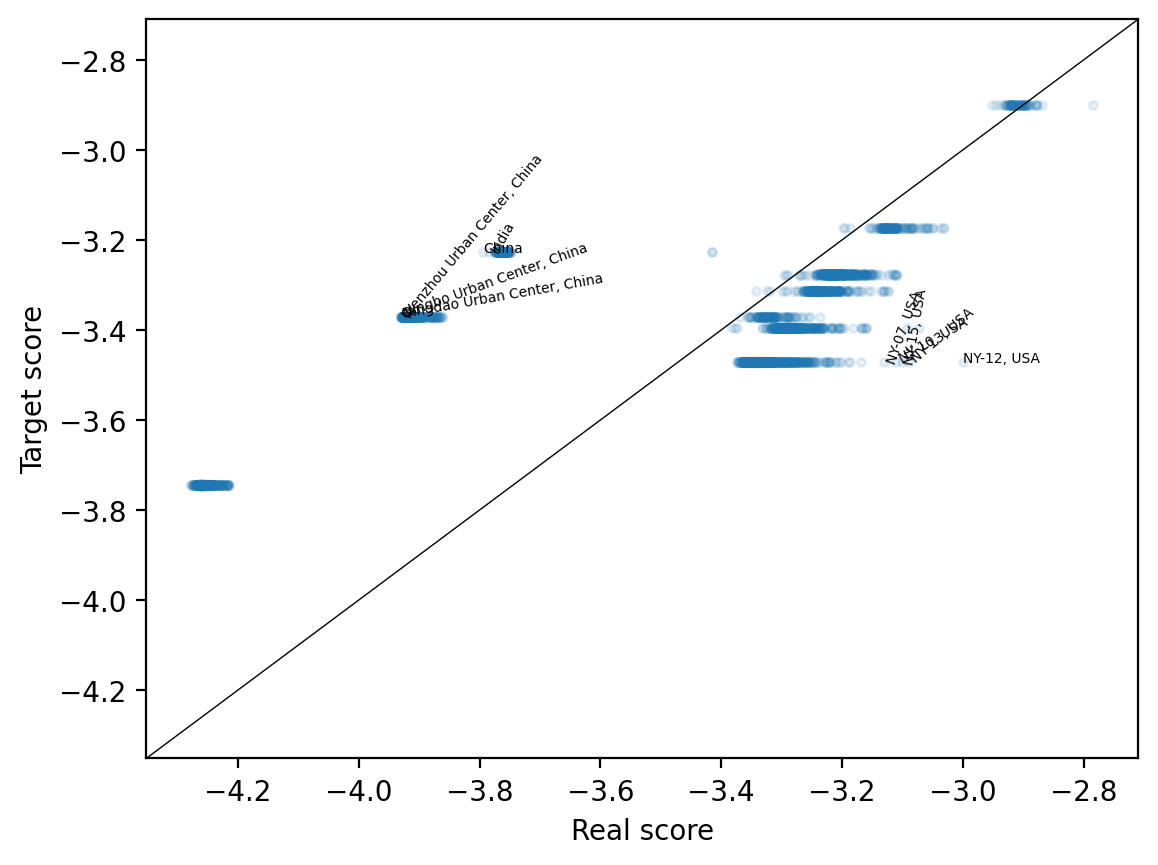

In [29]:
plot_conversions(np.log10(ga), np.log10(geo_target), qqp.all_geographies)

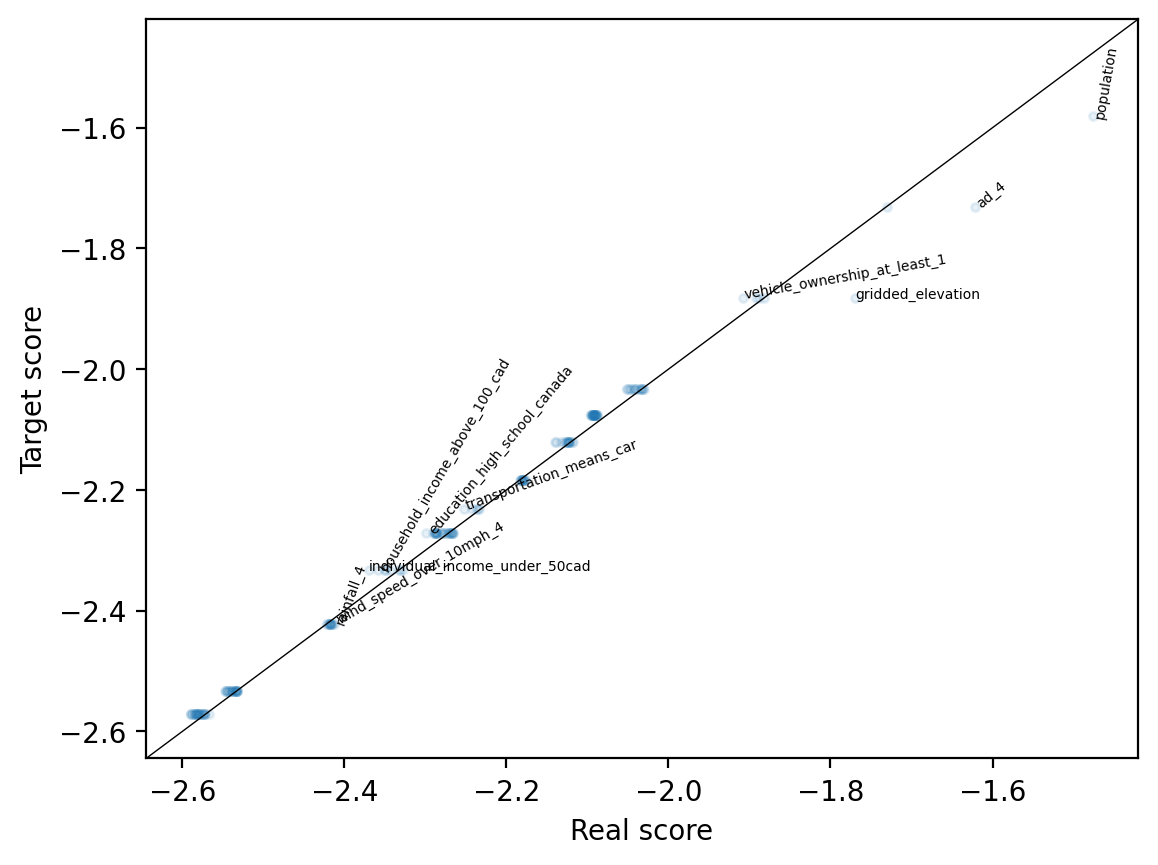

In [30]:
plot_conversions(np.log10(sa), np.log10(stat_target), qqp.all_stats)

In [31]:
from scipy.sparse import coo_array

In [32]:
[len(qs) / 1e6 for qs in questions_by_number]

NameError: name 'questions_by_number' is not defined

In [ ]:
import cvxpy as cp

In [ ]:
question_weights = [cp.Variable(len(qs)) for qs in questions_by_number]

In [ ]:
constraints = []
constraints += [q.sum() == 1 for q in question_weights]
constraints += [question_index_constraint(questions_by_number, question_weights, len(geo_to_index))]
# constraints += [statistics_constraint(questions_by_number, question_weights, len(stat_to_index))]
entropy = sum(cp.entr(q).sum() for q in question_weights)

In [ ]:
prob = cp.Problem(cp.Maximize(entropy), constraints)
# soln = prob.solve(verbose = True)
# assert prob.status == 'optimal'

In [ ]:
help(prob.solve)

In [ ]:
daha = prob.get_problem_data(solver='CLARABEL')

In [ ]:
with open("/home/kavi/temp/temp.pkl", "wb") as f:
    import pickle; pickle.dump(daha, f)

In [ ]:
prob.status

In [ ]:
question_weights[0].value

In [ ]:
question_weights[0].value

In [ ]:
questions_by_number[0].stat_indices.min()

In [ ]:
adj_d = compute_adjusted_difficulties(typ, stats)

In [ ]:
adj_d.shape

In [ ]:
# vals_a, vals_b = values_non_nan[:, None], values_non_nan[None]

In [ ]:
((5 < adj_pct_diff) & (adj_pct_diff < 40)).sum()